# 1. Decision Tree

## 1.1 Numpy from scratch

### 1.1.1 Make a small dataset

In [1]:
import pandas as pd

data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal'],
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes']
}

df = pd.DataFrame(data)

df

,Outlook,Humidity,PlayTennis
0,Sunny,High,No
1,Sunny,High,No
2,Overcast,High,Yes
3,Rain,High,Yes
4,Rain,Normal,Yes
5,Rain,Normal,No
6,Overcast,Normal,Yes
7,Sunny,High,No
8,Sunny,Normal,Yes
9,Rain,Normal,Yes


### 1.1.2 Gini impurity & Entropy

$\text{Gini}(S) = 1 - \sum_{i=1}^{k} p_i^2$

$\text{Entropy}(S) = - \sum_{i=1}^{k} p_i \log_2 p_i$

如果所有类别完全一样（如 y2），Gini 和 Entropy 都为 0，表示纯度最高；

类别越混乱，Gini 和 Entropy 越高；

Gini 计算更快，Entropy 更精确，二者常用于决策树中的“最优特征选择”。

Gini 更偏向于 “快速划分”，不涉及对数，计算快；

Entropy 更精确，有信息理论支持，但涉及 log，计算略慢；

决策树中 CART 使用 Gini，ID3/C4.5 使用 Entropy；

二者效果通常接近，可根据任务需求选取。

In [2]:
import numpy as np

In [45]:
def calc_gini(y):
    classes, counts = np.unique(y, return_counts=True) #classes array contain sorted unique elements found in y and counts are counts
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

In [13]:
def calc_entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

In [12]:
##example of np.unique()
y = np.array([1, 2, 2, 3, 1, 4, 2])
classes, counts = np.unique(y, return_counts=True)
print(classes)  # Output: [1 2 3 4]
print(counts)   # Output: [2 3 1 1]

[1 2 3 4]
[2 3 1 1]


### 1.1.3 Information Gain

information gain usually the entropy-based, can use gini too

In [14]:
def impurity_gain(y, x_col, criterion="entropy"):
    base = calc_entropy(y) if criterion == "entropy" else calc_gini(y)
    values, counts = np.unique(x_col, return_counts=True)
    weighted_impurity = 0

    for v in values:
        y_sub = y[x_col == v]
        weight = len(y_sub) / len(y)
        impurity = calc_entropy(y_sub) if criterion == 'entropy' else calc_gini(y_sub)
        weighted_impurity += weight * impurity

    return base - weighted_impurity

### 1.1.4 Tree Strucutre Construction

In [46]:
def build_tree(X, y, features, criterion='entropy', depth=0):
    if len(np.unique(y)) == 1:
        return {'label': y.iloc[0]}  # 修复：用 iloc 取值
    if len(features) == 0:
        return {'label': y.value_counts().idxmax()}  # 更鲁棒地选多数类

    gains = [impurity_gain(y, X[feat], criterion) for feat in features]
    best_feat = features[np.argmax(gains)]

    tree = {'feature': best_feat, 'nodes': {}}
    for value in X[best_feat].unique():
        sub_X = X[X[best_feat] == value].reset_index(drop=True)
        sub_y = y[X[best_feat] == value].reset_index(drop=True)
        subtree = build_tree(sub_X, sub_y, [f for f in features if f != best_feat], criterion, depth + 1)
        tree['nodes'][value] = subtree

    return tree

### 1.1.5 Visualization

In [37]:
def print_tree(tree, indent=""):
    if 'label' in tree:
        print(indent + "Label:", tree['label'])
    else:
        print(indent + "Feature:", tree['feature'])
        for val, subtree in tree['nodes'].items():
            print(indent + f"== {val} =>")
            print_tree(subtree, indent + "  ")

### 1.1.6 application to the dataset

In [38]:
X = df[["Outlook", "Humidity"]]
y = df["PlayTennis"]
features = X.columns.tolist()

In [39]:
X

,Outlook,Humidity
0,Sunny,High
1,Sunny,High
2,Overcast,High
3,Rain,High
4,Rain,Normal
5,Rain,Normal
6,Overcast,Normal
7,Sunny,High
8,Sunny,Normal
9,Rain,Normal


In [40]:
y

0     No
1     No
2    Yes
3    Yes
4    Yes
5     No
6    Yes
7     No
8    Yes
9    Yes
Name: PlayTennis, dtype: object

In [41]:
features

['Outlook', 'Humidity']

In [42]:
tree = build_tree(X, y, features, criterion="entropy")

In [43]:
print_tree(tree)

Feature: Outlook
== Sunny =>
  Feature: Humidity
  == High =>
    Label: No
  == Normal =>
    Label: Yes
== Overcast =>
  Label: Yes
== Rain =>
  Feature: Humidity
  == High =>
    Label: Yes
  == Normal =>
    Label: Yes


In [47]:
tree_gini = build_tree(X, y, features, criterion='gini')
print_tree(tree_gini)

Feature: Outlook
== Sunny =>
  Feature: Humidity
  == High =>
    Label: No
  == Normal =>
    Label: Yes
== Overcast =>
  Label: Yes
== Rain =>
  Feature: Humidity
  == High =>
    Label: Yes
  == Normal =>
    Label: Yes


In [48]:
df

,Outlook,Humidity,PlayTennis
0,Sunny,High,No
1,Sunny,High,No
2,Overcast,High,Yes
3,Rain,High,Yes
4,Rain,Normal,Yes
5,Rain,Normal,No
6,Overcast,Normal,Yes
7,Sunny,High,No
8,Sunny,Normal,Yes
9,Rain,Normal,Yes


## 1.2 Sklearn DT

### 1.2.1 Making data

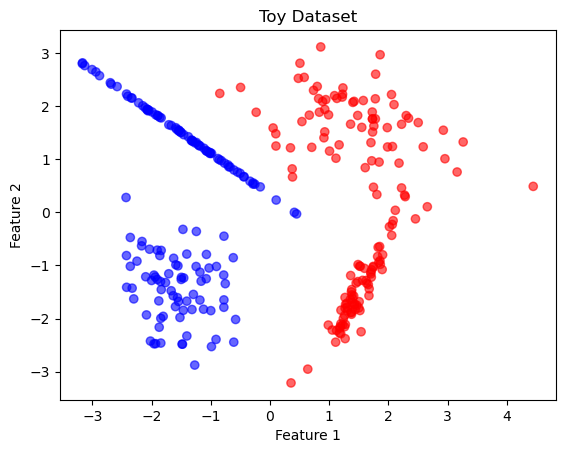

In [49]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd

X, y = make_classification(n_samples=300, n_features=2, 
                           n_redundant=0, n_informative=2,
                           random_state=42, class_sep=1.5)

# 可视化
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Toy Dataset")
plt.show()

### 1.2.2 Train the DT

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

### 1.2.3 evaluation

In [51]:
from sklearn.metrics import accuracy_score

y_pred = tree_clf.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))


Accuracy: 1.0


### 1.2.4 Visualizing the decision boundary

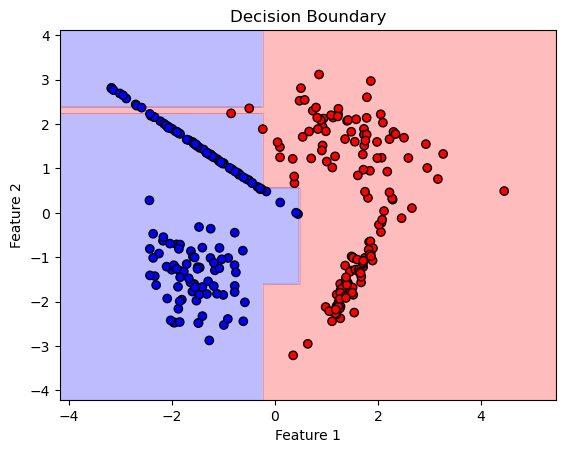

In [52]:
def plot_decision_boundary(clf, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundary(tree_clf, X, y)

### 1.2.5 Visualize the tree

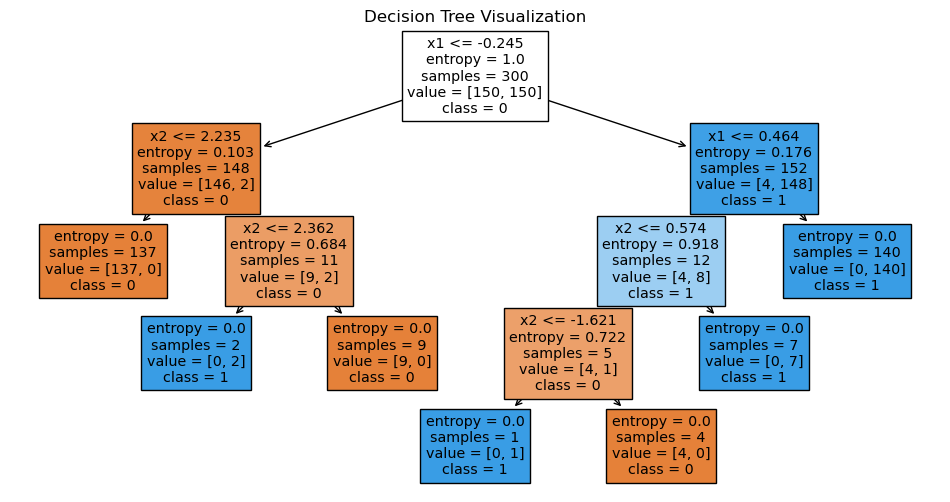

In [53]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(tree_clf, filled=True, feature_names=["x1", "x2"], class_names=["0", "1"])
plt.title("Decision Tree Visualization")
plt.show()

### 1.2.6 feature importance

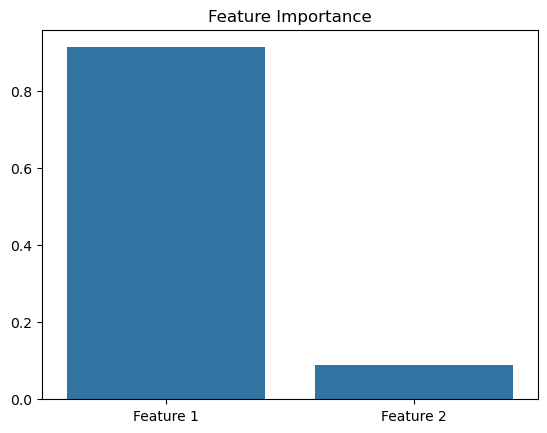

In [54]:
import seaborn as sns

features = ["Feature 1", "Feature 2"]
importances = tree_clf.feature_importances_

sns.barplot(x=features, y=importances)
plt.title("Feature Importance")
plt.show()

## 1.3 using numpy for sklearn implementation mimic (kind of revised 1.1)

In [56]:
from collections import Counter

In [58]:
def gini(y):
    counts = Counter(y)
    probs = np.array([v / len(y) for v in counts.values()])
    return 1 - np.sum(probs ** 2)

In [59]:
def entropy(y):
    counts = Counter(y)
    probs = np.array([v / len(y) for v in counts.values()])
    return -np.sum(probs * np.log2(probs + 1e-9))

In [61]:
def information_gain(y, y_left, y_right, criterion="gini"):
    if criterion == "gini":
        impurity = gini
    elif criterion == "entropy":
        impurity = entropy
    else:
        raise ValueError("criterion must be 'gini' or 'entropy'")

    base = impurity(y)
    p = len(y_left) / len(y)
    return base - p * impurity(y_left) - (1 - p) * impurity(y_right)

In [68]:
def best_split(X, y, feature_index, criterion="gini"):
    x = X[:, feature_index] #choose the feature
    sorted_idx = np.argsort(x) #sort x eg[50,600,10,14], return sorted index [2,3,0,1]
    x_sorted = x[sorted_idx]
    y_sorted = y[sorted_idx]

    best_gain = -1
    best_thresh = None

    #traverse all the possible split positions
    for i in range(1, len(x_sorted)):
        if x_sorted[i] == x_sorted[i - 1]: #equal then skip to avoid duplicated splitting
            continue
        threshold = (x_sorted[i] + x_sorted[i - 1]) / 2 #not equal, then choose the mid point as the threshold
        y_left = y_sorted[:i]
        y_right = y_sorted[i:]
        gain = information_gain(y, y_left, y_right, criterion)
        if gain > best_gain:
            best_gain = gain
            best_thresh = threshold

    return best_thresh, best_gain

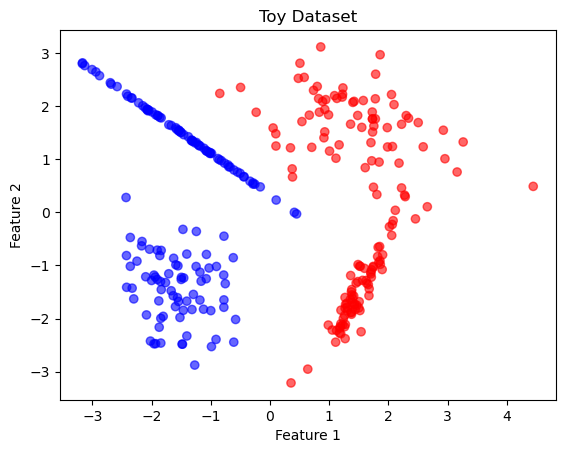

Best threshold: -0.2449850878263493, Info gain: 0.4609


In [69]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd

X, y = make_classification(n_samples=300, n_features=2, 
                           n_redundant=0, n_informative=2,
                           random_state=42, class_sep=1.5)

# 可视化
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Toy Dataset")
plt.show()

thresh, gain = best_split(X, y, feature_index=0, criterion='gini')
print(f"Best threshold: {thresh}, Info gain: {gain:.4f}")

In [73]:
def build_tree(X, y, features, depth=0, max_depth=None, criterion="gini", min_sample_split=2):
    """
    construct the recersive way
    X: (m, n)
    y: (m,)
    features: feature index arrays, eg [0,1,2]
    depth: current depth
    max_depth: maximum depth
    criterion: use "gini" or "entropy"
    min_sample_splits: if the sample size less than this value then stop splitting
    """

    if len(np.unique(y)) == 1:
        return {"label": y[0]} # if only one class

    if len(features) == 0 or (max_depth is not None and depth >= max_depth) or len(y) < min_sample_split:
        majority_label = np.bincount(y).argmax()
        return {"label": majority_label} #if no feature can used to split, then just return majority

    #search the best split among all features
    best_feat = None
    best_thresh = None
    best_gain = -1

    for feat in features:
        thresh, gain = best_split(X, y, feat, criterion)
        if gain > best_gain:
            best_feat = feat# 递归构建左右子树
            best_thresh = thresh
            best_gain = gain

    #if in above step cannot find such feature
    if best_gain <= 0:
        majority_label = np.bincount(y).argmax()
        return {'label': majority_label}

    #if can use above step to find such feature
    left_mask = X[:, best_feat] <= best_thresh
    right_mask = X[:, best_feat] > best_thresh
    X_left, X_right, y_left, y_right = X[left_mask], X[right_mask], y[left_mask], y[right_mask]
    # till here, finish one depth splitting

    #then construct left and right subtree
    left_subtree = build_tree(X_left, y_left, features, depth+1, max_depth, criterion, min_sample_split)
    right_subtree = build_tree(X_right, y_right, features, depth+1, max_depth, criterion, min_sample_split)

    return {
        "feature": best_feat,
        "threshold": best_thresh,
        "left": left_subtree,
        "right": right_subtree
    }

    

In [74]:
features = list(range(X.shape[1]))  # [0, 1, 2]
tree = build_tree(X, y, features, max_depth=3, )
tree

{'feature': 0,
 'threshold': -0.2449850878263493,
 'left': {'feature': 1,
  'threshold': 2.234595664143791,
  'left': {'label': 0},
  'right': {'feature': 0,
   'threshold': -1.7159014816918092,
   'left': {'label': 0},
   'right': {'label': 1}}},
 'right': {'feature': 0,
  'threshold': 0.4636798219952003,
  'left': {'feature': 1,
   'threshold': 0.5739775987059107,
   'left': {'label': 0},
   'right': {'label': 1}},
  'right': {'label': 1}}}

In [75]:
def predict_tree(tree, x):
    """
    for single sample x, using the tree to do a prediction
    tree: the tree built by built_tree()
    x: a vector
    return: predicted label
    """

    if "label" in tree:
        return tree["label"] #if leaf node has the "label" then return

    feat = tree["feature"]
    thresh = tree["threshold"]

    if x[feat] <= thresh:
        return predict_tree(tree["left"], x)
    else:
        return predict_tree(tree["right"], x)

In [76]:
def predict_batch(tree, X):
    """
    对多个样本批量预测
    X: shape (m, n) 的样本矩阵
    返回：预测结果数组
    """
    return np.array([predict_tree(tree, x) for x in X])

In [77]:
X_test, y_test = make_classification(n_samples=50, n_features=2, 
                           n_redundant=0, n_informative=2,
                           random_state=42, class_sep=1.5)

In [78]:
y_pred = predict_batch(tree, X_test)

In [79]:
acc = np.mean(y_pred == y_test)
print("Accuracy:", acc)

Accuracy: 0.96


# 2. Random Forest

## 2.1 Sklearn Random Forest

### 2.1.1 Make data

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

In [81]:
X, y = make_classification(
    n_samples=500, n_features=5, n_informative=3, n_redundant=0,
    n_classes=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### 2.1.2 Train

In [82]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, oob_score=True, random_state=42)

### 2.1.3 Prediction

In [83]:
y_pred = rf.predict(X_test)

### 2.1.4 Evaluation

In [84]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        72
           1       0.97      0.91      0.94        78

    accuracy                           0.94       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.94      0.94      0.94       150



### 2.1.5 Visualize important features

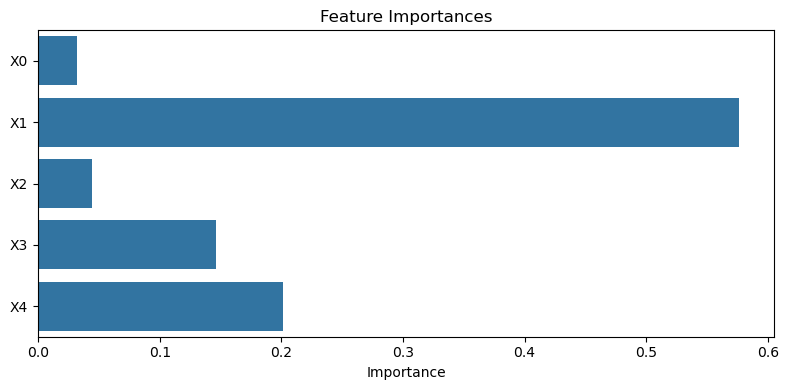

In [85]:
plt.figure(figsize=(8, 4))
sns.barplot(x=rf.feature_importances_, y=[f"X{i}" for i in range(X.shape[1])])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## 2.2 Numpy random forest

In [92]:
class RandomForestClassifierScratch:
    def __init__(self, n_estimators=10, max_depth=None, max_features=None, criterion="gini"):
        """
        n_estimators: 决策树数量
        max_depth: 每棵树的最大深度
        max_features: 每次划分考虑的最大特征数
        criterion: "gini" 或 "entropy"
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.trees = [] #store every tree
        self.features_per_tree = [] # store features index by each tree

    def fit(self, X, y):
        self.trees = []
        self.features_per_tree = []
        n_samples, n_features = X.shape

        for _ in range(self.n_estimators):
            #1bootstrap
            indices = np.random.choice(n_samples, n_samples, replace=True) #np.random.choice([0,n-1] can be used, pick n, can duplicated)
            X_sample = X[indices]
            y_sample = y[indices]

            #2. random select max_feautres for train that tree
            if self.max_features is None:
                max_feats = int(np.sqrt(n_features))
            else:
                max_feats = self.max_features

            feature_indices = np.random.choice(n_features, max_feats, replace=False)

            #3. train the tree
            tree = build_tree(X_sample[:, feature_indices], y_sample, features=list(range(max_feats)),
                              criterion=self.criterion, max_depth=self.max_depth)
            self.trees.append(tree)
            self.features_per_tree.append(feature_indices)


    def predict(self, X):
        tree_preds = []

        for tree, feat_idx in zip(self.trees, self.features_per_tree):
            X_subset = X[:, feat_idx]
            preds = np.array([predict_tree(tree, x) for x in X_subset])
            tree_preds.append(preds)

        #vote
        tree_preds = np.array(tree_preds).T #shape (n_samples, n_estimators)
        y_pred = []
        for row in tree_preds:
            vote = Counter(row).most_common(1)[0][0]
            y_pred.append(vote)
        return np.array(y_pred)

In [93]:
rf = RandomForestClassifierScratch(n_estimators=5, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7533333333333333
